In [1]:
import os
from itertools import product as cart_product

import numpy as np
import PIL.Image as Image
from skimage import util as imgutil
import matplotlib.pyplot as plt

import torch
from torch import nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.ops import DeformConv2d
from torch.nn.modules.utils import _pair
from torchinfo import summary

from torchmetrics import Accuracy

# Jupyter Notebook Notes
**Created by**: Spencer Chang

**Related Presentation**: [Deformable Convolutions](https://uflorida-my.sharepoint.com/:p:/g/personal/chang_spencer_ufl_edu/EVmZVAsz-SZNumKvtgYPn94B88vRN2L3hspiziJYRIkM8A?e=mSxZcw) by Spencer Chang and Jesse Weber.

**Objective:** Make a quick and dirty implementation of the deformable convolution (v1) as mentioned in their [original paper](https://arxiv.org/abs/1703.06211). Overfit a DeformConvNet and ConvNet and evaluate the module's learned features when modifying given sample images with one or more random affine transformations.

# Deformable Convolution

Deformable Convolution / Deformable RoI Pooling Pseudo-code
- Branch 1A - convolution on input feature map same size as the input feature map (2 filters for x and y coords)
- Branch 1B - Filters learned from this are used to index the values input to each filter of the normal Conv2d (Branch 2)
- Branch 2 - Either use deform_conv2d or add a custom code block where you've implemented the offsetting based on the given filter values.
- Branch 2 Thoughts - How to do this in an entirely custom way with available tools is unclear to me.

In [2]:
class DeformConv(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 num_deformable_groups=1):
        super(DeformConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding = _pair(padding)
        self.dilation = _pair(dilation)
        self.num_deformable_groups = num_deformable_groups

        self.offset_conv = nn.Conv2d(in_channels, 2 * self.kernel_size[0] * self.kernel_size[1],
                                     kernel_size=self.kernel_size,
                                     stride=self.stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     groups=self.num_deformable_groups,
                                     bias=False)
        self.offset_wgts = self.offset_conv.weight

        self.deform_conv = DeformConv2d(in_channels, out_channels,
                                        kernel_size=self.kernel_size,
                                        stride=self.stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        groups=self.num_deformable_groups)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / np.sqrt(n)
        self.offset_wgts.data.uniform_(-stdv, stdv).to(torch.double)

    def forward(self, input):
        offsets = self.offset_conv(input)
        return self.deform_conv(input, offsets)


In [3]:
class ConvNet(torch.nn.Module):
    def __init__(self,
                 num_classes,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1):
        super(ConvNet, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_mod = nn.Conv2d(in_channels,
                                  out_channels,
                                  kernel_size,
                                  stride=stride,
                                  padding=padding,
                                  dilation=dilation,
                                  groups=groups)
        self.nonlin = nn.ReLU()
        
        self.pool = nn.AdaptiveAvgPool2d((10, 10))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels * 100, num_classes)
        )

    def forward(self, input):
        x = self.nonlin(self.conv_mod(input))
        x = self.pool(x)
        return self.fc(x)

In [4]:
class DeformNetwork(torch.nn.Module):
    def __init__(self,
                 num_classes,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1):
        super(DeformNetwork, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_mod = DeformConv(in_channels,
                                   out_channels,
                                   kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   dilation=dilation,
                                   num_deformable_groups=groups)
        self.nonlin = nn.ReLU()
        
        self.pool = nn.AdaptiveAvgPool2d((10, 10))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_channels * 100, num_classes)
        )

    def forward(self, input):
        x = self.nonlin(self.conv_mod(input.to(torch.float)))
        x = self.pool(x)
        return self.fc(x)

In [8]:
class MiniFCN(nn.Module):
    """
    Fully-convolutional network that should learn mainly
        structural texture information
    Modeled after a github repo that reproduced the OG paper's results:
        https://github.com/wkentaro/pytorch-fcn/blob/main/torchfcn/models/fcn8s.py
    """
    def __init__(self,
                 n_class=1,
                 in_channels=1,
                 first_feat=2,
                 second_feat=4):
        """
        As of 12/6/2023, I'm expecting an input of 64x64 here, so much of the original
            FCN is removed (last two convolutional sections).
        """
        super(MiniFCN, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_class

        # conv1
        self.convmod_1 = nn.Sequential(
            nn.Conv2d(self.in_channels, first_feat, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.convmod_2 = nn.Sequential(
            nn.Conv2d(first_feat, second_feat, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # fc4
        self.fc4 = nn.Conv2d(second_feat, second_feat, kernel_size=4)
        self.relu4 = nn.ReLU(inplace=True)

        self.score_fr    = nn.Conv2d(second_feat, n_class, 1)
        self.score_pool1 = nn.Conv2d(first_feat, n_class, 1)

        self.up_interpolate = nn.functional.interpolate
        ### Don't yet have an equivalent for this in Histogram Layer
        self.upscore1 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore_fin = nn.ConvTranspose2d(
            n_class, n_class, 10, stride=2, bias=False)

    def forward(self, x):
        h = x  # 1/1

        h = self.pool1(self.convmod_1(h))  # 1/2
        pool1 = h

        h = self.pool2(self.convmod_2(h))  # 1/4
        h = self.relu4(self.fc4(h))

        h = self.score_fr(h)
        h = self.upscore1(h)
        upscore1c = h  # 1/4

        h = self.score_pool1(pool1)  # 1/2
        pad_r = (h.shape[-2] - upscore1c.shape[-2]) // 2
        pad_c = (h.shape[-1] - upscore1c.shape[-1]) // 2
        h = h[
            ...,
            pad_r:pad_r + upscore1c.shape[-2],
            pad_c:pad_c + upscore1c.shape[-1]
        ]

        h = upscore1c + h  # 1/2
        h = self.upscore_fin(h)  # 1/1
        pad_r = (h.shape[-2] - x.shape[-2]) // 2
        pad_c = (h.shape[-1] - x.shape[-1]) // 2
        h = h[
            ...,
            pad_r:pad_r + x.shape[-2],
            pad_c:pad_c + x.shape[-1]
        ]
        
        return h

In [9]:
class DeformFCN(torch.nn.Module):
    def __init__(self,
                 num_classes,
                 in_channels,
                 first_feat=2,
                 second_feat=4):
        super(DeformFCN, self).__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels

        # conv1
        self.convmod_1 = nn.Sequential(
            DeformConv(self.in_channels, first_feat, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.convmod_2 = nn.Sequential(
            DeformConv(first_feat, second_feat, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # fc4
        self.fc4 = nn.Conv2d(second_feat, second_feat, kernel_size=4)
        self.relu4 = nn.ReLU(inplace=True)

        self.score_fr    = nn.Conv2d(second_feat, num_classes, 1)
        self.score_pool1 = nn.Conv2d(first_feat, num_classes, 1)

        ### Don't yet have an equivalent for this in Histogram Layer
        self.upscore1 = nn.ConvTranspose2d(
            num_classes, num_classes, 4, stride=2, bias=False)
        self.upscore_fin = nn.ConvTranspose2d(
            num_classes, num_classes, 10, stride=2, bias=False)

    def forward(self, x):
        h = x  # 1/1

        h = self.pool1(self.convmod_1(h))  # 1/2
        pool1 = h

        h = self.pool2(self.convmod_2(h))  # 1/4
        h = self.relu4(self.fc4(h))

        h = self.score_fr(h)
        h = self.upscore1(h)
        upscore1c = h  # 1/4

        h = self.score_pool1(pool1)  # 1/2
        pad_r = (h.shape[-2] - upscore1c.shape[-2]) // 2
        pad_c = (h.shape[-1] - upscore1c.shape[-1]) // 2
        h = h[
            ...,
            pad_r:pad_r + upscore1c.shape[-2],
            pad_c:pad_c + upscore1c.shape[-1]
        ]

        h = upscore1c + h  # 1/2
        h = self.upscore_fin(h)  # 1/1
        pad_r = (h.shape[-2] - x.shape[-2]) // 2
        pad_c = (h.shape[-1] - x.shape[-1]) // 2
        h = h[
            ...,
            pad_r:pad_r + x.shape[-2],
            pad_c:pad_c + x.shape[-1]
        ]
        
        return h

### Binary Segmentation Dataset

In [10]:
class DeformDataset(Dataset):
    def __init__(self, n_samples, transform=None, img_shape=(64, 64)):
        '''
        samples: samples to generate per class
        '''
        if img_shape[0] > 100 or img_shape[1] > 100:
            ValueError(f"Both img_shape values must be < 100; received {img_shape}")
        self.shape = img_shape[:2]
        self.n_samples = n_samples
        self.transform = transforms.ToTensor() if transform is None else transform
        self.samples = []
        self.targets = []

        # n_each = n_samples // 2
        img1 = np.array(Image.open("digit_1.png")) / 255
        img2 = np.array(Image.open("digit_7.png")) / 255

        # class_1 = self.__transform_img__(img1, n_each)
        # class_2 = self.__transform_img__(img2, n_each)

        self.samples = [img1, img2]
        self.targets = [0, 1]

        # img_list = true_imgs + torch.randn_like(true_imgs) / 2

        # # x_data = img_list.unsqueeze(1).to(torch.float)
        # # y_data = true_imgs.to(torch.long)
    
    def __len__(self):
        return len(self.samples)
    
    def __transform_img__(self, img:np.ndarray, N:int):

        pass

    def __get_struct_imgs__(self, n_tiles=400):
        ## Construct the Structural Texture Tiles ##
        grid_sz = int(np.sqrt(n_tiles))

        struct1 = np.ones((8, 8))    # Generation: Must be alternated within each row
        struct2 = np.array(          # Generation: Must be used for each tile
            [[0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1, 1, 1, 1],
            [0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 0, 0]]
        )
        struct3 = np.array(          # Generation: Must be used for each tile
            [[0, 0, 1, 1, 1, 1, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0],
            [0, 0, 1, 1, 1, 1, 0, 0]]
        )
        struct4 = np.array(          # Generation: Must be used for each tile
            [[1, 1, 0, 0, 0, 0, 1, 1],
             [1, 0, 0, 1, 1, 0, 0, 1],
             [0, 0, 1, 0, 0, 1, 0, 0],
             [0, 1, 0, 0, 0, 0, 1, 0],
             [0, 1, 0, 0, 0, 0, 1, 0],
             [0, 0, 1, 0, 0, 1, 0, 0],
             [1, 0, 0, 1, 1, 0, 0, 1],
             [1, 1, 0, 0, 0, 0, 1, 1]]
        )
        # struct4 = np.array(          # Generation: May be used for each tile or alternated
        #     [[0, 0, 0, 1, 1, 0, 0, 0],
        #      [0, 0, 0, 1, 1, 0, 0, 0],
        #      [0, 0, 1, 1, 1, 0, 0, 1],
        #      [0, 1, 1, 1, 1, 0, 1, 1],
        #      [0, 1, 0, 1, 1, 1, 1, 0],
        #      [1, 0, 0, 1, 1, 1, 0, 0],
        #      [1, 0, 0, 1, 1, 0, 0, 0],
        #      [0, 0, 0, 1, 1, 0, 0, 0]]
        # )
        struct5 = np.array(          # Generation: Must be used for each tile
            [[1, 0, 0, 0, 0, 1, 1, 1],
             [0, 1, 0, 1, 1, 0, 0, 1],
             [0, 0, 1, 0, 0, 0, 0, 1],
             [0, 1, 1, 0, 0, 0, 1, 0],
             [0, 1, 0, 0, 0, 0, 1, 0],
             [1, 0, 0, 0, 1, 1, 0, 0],
             [1, 0, 0, 1, 1, 0, 1, 0],
             [1, 1, 1, 0, 0, 0, 0, 1]]
        )

        # Generate base images with the different structural textures
        ### CLASS 1 ###
        tile_list = []
        for idx in range(n_tiles):
            if (idx + idx // grid_sz) % 2 == 0:
                tile_list.append(struct1)
            else:
                tile_list.append(np.zeros_like(struct1))
        class_1 = imgutil.montage(tile_list, grid_shape=(grid_sz, grid_sz))[..., np.newaxis]

        ### CLASS 2 ###
        tile_list = []
        for idx in range(n_tiles):
            tile_list.append(struct2)
        class_2 = imgutil.montage(tile_list, grid_shape=(grid_sz, grid_sz))[..., np.newaxis]

        ### CLASS 3 ###
        tile_list = []
        for idx in range(n_tiles):
            tile_list.append(struct3)
        class_3 = imgutil.montage(tile_list, grid_shape=(grid_sz, grid_sz))[..., np.newaxis]

        ### CLASS 4 ###
        tile_list = []
        for idx in range(n_tiles):
            tile_list.append(struct4)
        class_4 = imgutil.montage(tile_list, grid_shape=(grid_sz, grid_sz))[..., np.newaxis]

        ### CLASS 5 ###
        tile_list = []
        for idx in range(n_tiles):
            if (idx + idx // grid_sz) % 2 == 0:
                tile_list.append(struct5)
            else:
                tile_list.append(np.rot90(struct5))
        class_5 = imgutil.montage(tile_list, grid_shape=(grid_sz, grid_sz))[..., np.newaxis]
        
        if self.n_class == 2:
            return np.concatenate((class_1, class_2), axis=-1)
        elif self.n_class == 3:
            return np.concatenate((class_1, class_2, class_3), axis=-1)
        elif self.n_class == 4:
            return np.concatenate((class_1, class_2, class_3, class_4), axis=-1)
        else:
            return np.concatenate((class_1, class_2, class_3, class_4, class_5), axis=-1)

    def __getitem__(self, index):
        image = self.samples[index]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.targets[index], dtype=torch.long)
        return image, label

In [84]:
max_shr = 40
transform_list = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomAffine(0,
                                translate=(0, 0.5),)
                                # scale=(0.25, 1.25),
                                # shear=(-max_shr, max_shr, -max_shr, max_shr))
])
tr_dataset = DeformDataset(2, transform=transform_list)
train_loader = DataLoader(tr_dataset, batch_size=2, shuffle=True)

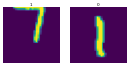

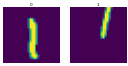

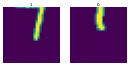

In [85]:
ep = 3
for e in range(ep):
    fig, axes = plt.subplots(1, 2, dpi=25)
    axes[0].axis('off')
    axes[1].axis('off')
    for batch in train_loader:
        axes[0].imshow(batch[0][0].squeeze())
        axes[1].imshow(batch[0][1].squeeze())
        axes[0].set_title(f"{batch[1][0]}")
        axes[1].set_title(f"{batch[1][1]}")

### MNIST Dataset

In [10]:
# batch_size = 16
# tr_data = MNIST("./", transform=transforms.ToTensor())
# train_loader = DataLoader(tr_data,
#                           batch_size=batch_size,
#                           shuffle=True)

In [11]:
# for batch in train_loader:
#     break

### Training Loop

In [86]:
n_classes = 2
in_channels = 1
out_channels = 3
kernel_size = 4
stride = 1
padding = 0
dilation = 1

deform_network = DeformNetwork(n_classes,
                               in_channels,
                               out_channels,
                               kernel_size,
                               stride=stride,
                               padding=padding,
                               dilation=dilation)
conv_network = ConvNet(n_classes,
                       in_channels,
                       out_channels * 2,
                       kernel_size,
                       stride=stride,
                       padding=padding,
                       dilation=dilation)

# deform_network = DeformFCN(1, in_channels,
#                        first_feat=2, second_feat=4)
# conv_network = MiniFCN(1, in_channels,
#                        first_feat=2, second_feat=4)
print(summary(deform_network))
print(summary(conv_network))

Layer (type:depth-idx)                   Param #
DeformNetwork                            --
├─DeformConv: 1-1                        --
│    └─Conv2d: 2-1                       512
│    └─DeformConv2d: 2-2                 51
├─ReLU: 1-2                              --
├─AdaptiveAvgPool2d: 1-3                 --
├─Sequential: 1-4                        --
│    └─Flatten: 2-3                      --
│    └─Linear: 2-4                       602
Total params: 1,165
Trainable params: 1,165
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Conv2d: 1-1                            102
├─ReLU: 1-2                              --
├─AdaptiveAvgPool2d: 1-3                 --
├─Sequential: 1-4                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       1,202
Total params: 1,304
Trainable params: 1,304
Non-trainable params: 0


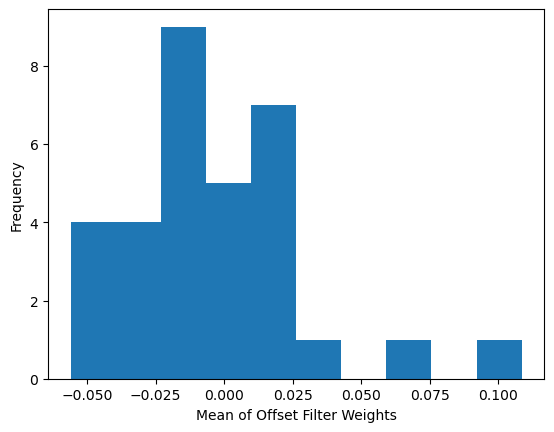

In [87]:
mean_offset_wgt = deform_network.conv_mod.offset_conv.weight.mean(dim=(-2, -1)).detach().squeeze()
plt.hist(mean_offset_wgt)
plt.xlabel("Mean of Offset Filter Weights")
_ = plt.ylabel("Frequency")

In [88]:
max_ep = 8000
learn_rate = 1e-3

# Define optimizer
deform_optim = torch.optim.Adam(deform_network.parameters(), lr=learn_rate)
conv_optim = torch.optim.Adam(conv_network.parameters(), lr=learn_rate)

# Define Loss criterion
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

deform_loss_track = []
conv_loss_track = []
for ep in range(max_ep):
    for b_idx, batch in enumerate(train_loader):
        imgs = batch[0].to(torch.float)
        labels = batch[1]

        # Zero gradients
        deform_network.zero_grad()
        conv_network.zero_grad()
        deform_optim.zero_grad()
        conv_optim.zero_grad()

        # Feedforward data
        deform_out = deform_network(imgs)
        conv_out = conv_network(imgs)

        # Compute (softmax) cross-entropy loss
        deform_loss = criterion(deform_out, labels)
        conv_loss = criterion(conv_out, labels)

        # Backpropagate loss
        deform_loss.backward()
        conv_loss.backward()

        # Optimize gradients
        deform_optim.step()
        conv_optim.step()

    if (ep + 1) % 500 == 0:
        print(f"E{ep+1:3d} | B{b_idx+1:4d}: d = {deform_loss:.4f}, c = {conv_loss:.4f}")
    if (ep + 1) % 100 == 0:
        deform_loss_track.append(deform_loss.item())
        conv_loss_track.append(conv_loss.item())
    # break

# Zero gradients
deform_network.zero_grad()
conv_network.zero_grad()
deform_optim.zero_grad()
conv_optim.zero_grad()

E500 | B   1: d = 0.0010, c = 0.0011
E1000 | B   1: d = 0.0017, c = 0.0018
E1500 | B   1: d = 0.0001, c = 0.0001
E2000 | B   1: d = 0.0000, c = 0.0000
E2500 | B   1: d = 0.0000, c = 0.0000
E3000 | B   1: d = 0.0000, c = 0.0000
E3500 | B   1: d = 0.0000, c = 0.0000
E4000 | B   1: d = 0.0000, c = 0.0000
E4500 | B   1: d = 0.0000, c = 0.0000
E5000 | B   1: d = 0.0000, c = 0.0000
E5500 | B   1: d = 0.0000, c = 0.0000
E6000 | B   1: d = 0.0000, c = 0.0000
E6500 | B   1: d = 0.0000, c = 0.0000
E7000 | B   1: d = 0.0000, c = 0.0000
E7500 | B   1: d = 0.0000, c = 0.0000
E8000 | B   1: d = 0.0000, c = 0.0000


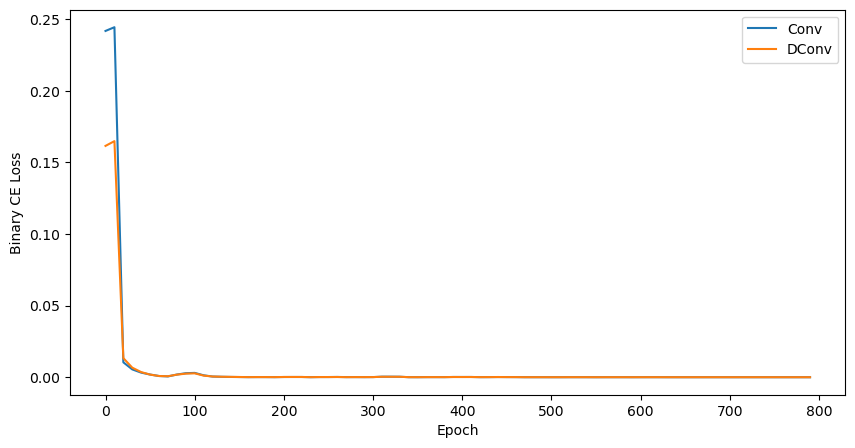

In [89]:
smooth_conv = np.convolve(conv_loss_track, np.ones(3), mode='same')
smooth_deform = np.convolve(deform_loss_track, np.ones(3), mode='same')
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, len(conv_loss_track)) * 10, smooth_conv, label='Conv')
plt.plot(np.arange(0, len(conv_loss_track)) * 10, smooth_deform, label='DConv')
plt.xlabel("Epoch")
plt.ylabel("Binary CE Loss")
plt.legend()

In [90]:
# with torch.no_grad():
#     for b_idx, batch in enumerate(train_loader):
#         imgs = batch[0]
#         t_img = batch[1]

#         # Feedforward data
#         deform_out = deform_network(imgs)
#         conv_out = conv_network(imgs)

#         fig, axes = plt.subplots(1, 4, dpi=150)
#         axes[0].imshow(imgs.squeeze())
#         axes[1].imshow(t_img.squeeze())
#         axes[2].imshow(deform_out.squeeze())
#         axes[3].imshow(conv_out.squeeze())
#         axes[0].axis('off')
#         axes[1].axis('off')
#         axes[2].axis('off')
#         axes[3].axis('off')

#         axes[0].set_title('Input')
#         axes[1].set_title('Binary mask')
#         axes[2].set_title('Deformable')
#         axes[3].set_title('Convolutional')

### Evaluate the Models' Performance
Ensure that - across multiple randomized affine transformations - the network is able to discriminate between the 1 and 7.

In [91]:
eval_ep = 100
with torch.no_grad():
    for ep_idx in range(eval_ep):
        for b_idx, batch in enumerate(train_loader):
            imgs = batch[0].to(torch.float)
            labels = batch[1]

            # Zero gradients
            # Feedforward data
            deform_out = deform_network(imgs)
            conv_out = conv_network(imgs)

            deform_out = deform_out.softmax(dim=-1).argmax(-1)
            conv_out = conv_out.softmax(dim=-1).argmax(-1)

            if ep_idx == 0 and b_idx == 0:
                true_labels = labels
                deform_pred = deform_out
                conv_pred = conv_out
            else:
                true_labels = torch.concatenate((true_labels, labels), dim=0)
                deform_pred = torch.concatenate((deform_pred, deform_out), dim=0)
                conv_pred = torch.concatenate((conv_pred, conv_out), dim=0)

In [92]:
acc_metrics = Accuracy('multiclass', num_classes=n_classes)
deform_acc = acc_metrics(deform_pred, true_labels)
conv_acc = acc_metrics(conv_pred, true_labels)

print(f"           ConvNet Acc: {conv_acc.item() * 100:.2f}%")
print(f"Deformable ConvNet Acc: {deform_acc.item() * 100:.2f}%")

           ConvNet Acc: 100.00%
Deformable ConvNet Acc: 100.00%


### Evaluate the Models' Feature Maps
Visualize the sampling locations for the deformable convolution. Attempt to gain some understanding of what's going on inside.

In [93]:
imgs = batch[0]
with torch.no_grad():
    deform_feats = deform_network.conv_mod(imgs.to(torch.float))
    conv_feats = conv_network.conv_mod(imgs.to(torch.float))

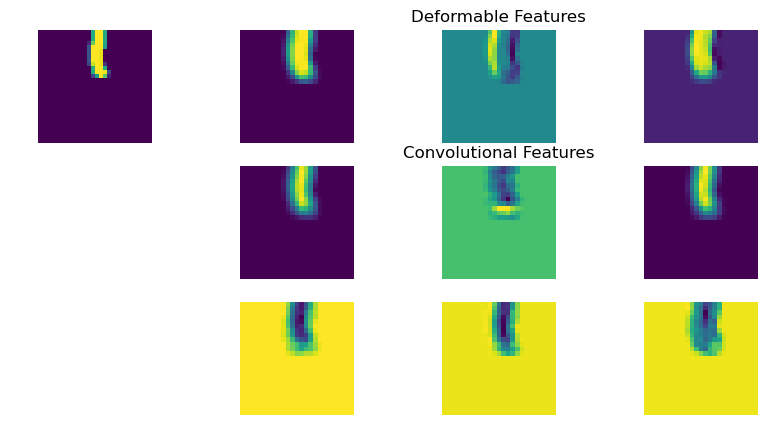

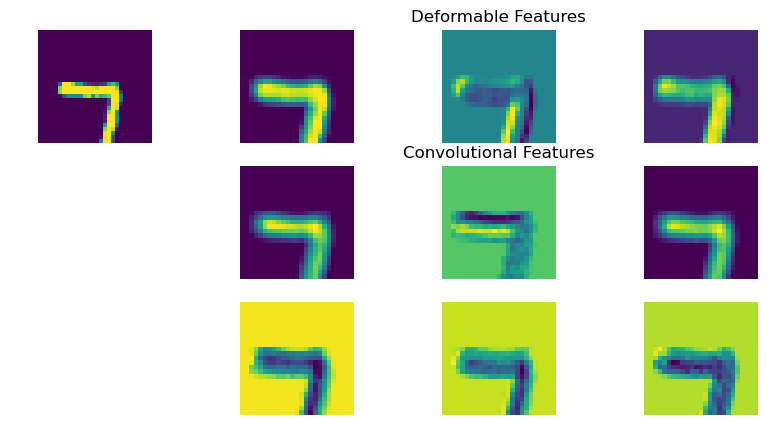

In [94]:
n_plots = 1

for _ in range(n_plots):
    for batch_idx, batch in enumerate(train_loader):
        imgs = batch[0]
        with torch.no_grad():
            deform_feats = deform_network.conv_mod(imgs.to(torch.float))
            conv_feats = conv_network.conv_mod(imgs.to(torch.float))
        for p_idx in range(imgs.shape[0]):
            fig, axes = plt.subplots(3, deform_feats.shape[1]+1, figsize=(10, 5))
            axes[0, 0].imshow(imgs[p_idx].squeeze())
            axes[0, 0].axis('off')
            axes[1, 0].axis('off')
            axes[2, 0].axis('off')

            axes[0, 2].set_title("Deformable Features")
            axes[1, 2].set_title("Convolutional Features")
            for ax_idx in range(deform_feats.shape[1]):
                axes[0, ax_idx+1].imshow(deform_feats[p_idx, ax_idx])
                axes[1, ax_idx+1].imshow(conv_feats[p_idx, ax_idx])
                axes[2, ax_idx+1].imshow(conv_feats[p_idx, 3 + ax_idx])
                axes[0, ax_idx+1].axis('off')
                axes[1, ax_idx+1].axis('off')
                axes[2, ax_idx+1].axis('off')
        if batch_idx > 0:
            break

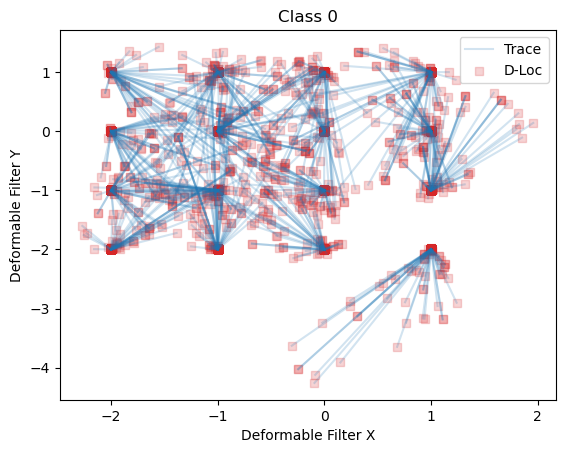

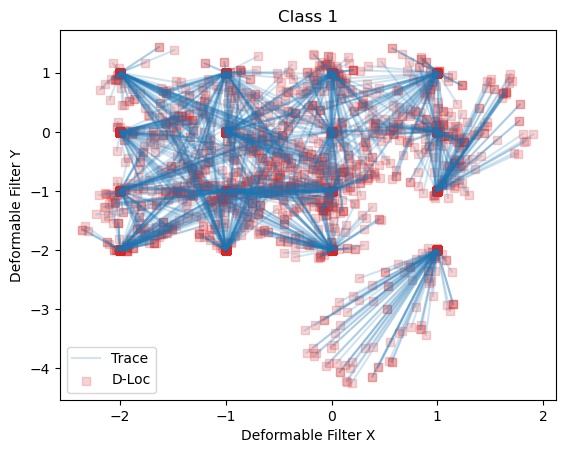

In [95]:
k_size = deform_network.conv_mod.kernel_size
n_deform = k_size[0] * k_size[1]
max_vis_pts = 5000

offset_feats = deform_network.conv_mod.offset_conv(imgs.to(torch.float)).detach().numpy()
for feat_idx, o_feat in enumerate(offset_feats):
    flat_offsets = o_feat.reshape((n_deform * 2, -1))
    kernel_x = [idx for idx in range(-k_size[0] // 2, k_size[0] // 2)]

    ###! Collect origin and point offset information !###
    R = list(cart_product(kernel_x, kernel_x))
    for d_idx in range(n_deform):
        o_pt = np.array([list(R[d_idx])] * flat_offsets.shape[-1])
        d_pt = list(zip(o_pt[:, 0], o_pt[:, 1], flat_offsets[2 * d_idx, :], flat_offsets[2 * d_idx + 1, :]))

        if d_idx == 0:
            pt_arr = d_pt
        else:
            pt_arr.extend(d_pt)
    pt_arr = np.array(pt_arr)

    ###! Visualize the deformed point locations for the filter. !###
    rand_idx = np.random.choice(range(pt_arr.shape[0]), size=max_vis_pts)
    plt.figure()
    plt.title(f"Class {batch[1][feat_idx]}")
    plt.xlabel("Deformable Filter X")
    plt.ylabel("Deformable Filter Y")
    for id, p_idx in enumerate(rand_idx):
        pt = pt_arr[p_idx, :]
        x_mv = [pt[0], pt[0] + pt[2]]
        y_mv = [pt[1], pt[1] + pt[3]]

        if id == 0:
            line_legend = 'Trace'
            mark_legend = 'D-Loc'
        else:
            line_legend = mark_legend = None
        plt.plot(x_mv, y_mv, alpha=0.2, color='tab:blue', label=line_legend)
        plt.scatter(x_mv[1], y_mv[1], alpha=0.2, marker=',', color='tab:red', label=mark_legend)
    plt.legend()
    plt.pause(0.1)

In [35]:
d_pred = deform_network(imgs.to(torch.float)).detach().softmax(dim=-1).argmax(dim=-1)
c_pred = conv_network(imgs.to(torch.float)).detach().softmax(dim=-1).argmax(dim=-1)
print(f"True labels: {batch[1]}")
print(f"  Deform Pred: {d_pred}")
print(f"  Conv Pred: {c_pred}")

True labels: tensor([0, 1])
  Deform Pred: tensor([0, 1])
  Conv Pred: tensor([0, 1])


# Deformable (RoI) Pooling

In [ ]:
## Deformable (RoI) Pooling
# Branch 1 - ???
# Branch 2 - ???